In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_blobs
import torch.nn as nn
from torch.optim import Adam, SGD
from cli import mdn_loss_function

In [97]:
T, _ = make_blobs()
T -= T.min()
T /= T.max()

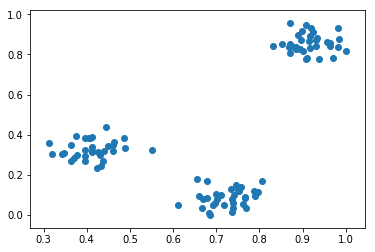

In [98]:
plt.scatter(T[:, 0], T[:, 1])

In [60]:
T.shape

torch.Size([100, 2])

In [99]:
T = torch.from_numpy(T)
T = T.float()

In [184]:
from torch.distributions import Normal
def mdn_loss_function(output, target, nb_components=1, nb_outputs=17*3):
    B = output.size(0)
    T = output.size(1)
    M = nb_components
    F = nb_outputs
    EPSILON = 1e-7
    o = output
    t = target
    o = o.view(B, T, M, F * 2 + 1)
    out_mu = o[:, :, :, 0:F]

    out_sigma = o[:, :, :, F:2*F]
    out_sigma = torch.exp(out_sigma)

    out_pi = o[:, :, :, 2*F:2*F+1]
    out_pi = nn.Softmax(dim=2)(out_pi)

    result = Normal(loc=out_mu, scale=out_sigma)
    target = target.view(B, T, 1, -1)
    result = torch.exp(result.log_prob(target))
    result = torch.sum(result * out_pi, dim=2)
    result = -torch.log(EPSILON + result)
    return result

In [257]:
nb_components = 3
F = nb_components * (2 * 2 + 1)
model = nn.Sequential(
    nn.Linear(F, F),
    nn.SELU(),
    nn.Linear(F, F),
    nn.SELU(),
    nn.Linear(F, F),
    nn.SELU(),
    nn.Linear(F, F),
    nn.SELU(),
    nn.Linear(F, F)
)
def weights_init(layer):
    if hasattr(layer, "weight"):
        print(layer)
        nn.init.xavier_uniform_(layer.weight)
model.apply(weights_init)
opt = Adam(model.parameters(), lr=1e-3)

Linear(in_features=15, out_features=15, bias=True)
Linear(in_features=15, out_features=15, bias=True)
Linear(in_features=15, out_features=15, bias=True)
Linear(in_features=15, out_features=15, bias=True)
Linear(in_features=15, out_features=15, bias=True)


In [267]:
n_iter = 0
bs = len(T)
for i in range(1000):
    for i in range(0, len(T), bs):
        t = T[i:i+bs]
        X = torch.zeros(len(t), F)
        h = model(X)
        o = h.view(h.size(0), 1, -1)
        t = t.view(t.size(0), 1, -1)
        opt.zero_grad()
        loss = mdn_loss_function(o, t, nb_components=nb_components, nb_outputs=2).sum()
        loss.backward()
        opt.step()
        if n_iter % 100 == 0:
            print(-loss.item())
        n_iter += 1 

115.20256042480469
115.01416015625
115.16619110107422
115.21222686767578
115.0818862915039
115.20828247070312
115.18043518066406
115.19271087646484
115.11602783203125
115.21247100830078


In [268]:
X = torch.zeros(len(T)*10, F)
O = model(X)
O = O.view(O.size(0), nb_components, -1)
mu = O[:, :, 0:2]
sig = O[:, :, 2:4]
sig = torch.exp(sig)
pi = O[:, :, 4:5]
pi = nn.Softmax(dim=1)(pi)
pi = pi.view(pi.size(0), pi.size(1))
pi_sample = torch.multinomial(pi, 1)
pi[:]=0
pi.scatter_(1, pi_sample, 1)
pi = pi.view(pi.size(0), pi.size(1), 1)
o = (torch.normal(mu, sig) * pi).sum(dim=1)
o = o.detach().cpu().numpy()

(1000, 2)


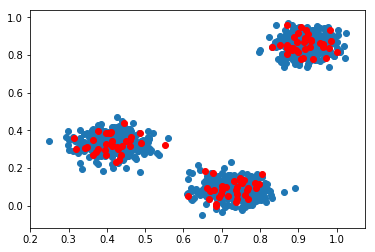

In [269]:
print(o.shape)
plt.scatter(o[:, 0], o[:, 1])
plt.scatter(T[:, 0], T[:, 1], color="red")
plt.show()